In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to load data
def load_data(file_path):
    return pd.read_csv(file_path)

# Function to visualize raw data
def plot_raw_data(data):
    plt.figure(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)
    plt.plot(data.index, data[LABEL_STATE], label=LABEL_STATE, color=COLOR_STATE, alpha=0.7)
    plt.xlabel('Time Index')
    plt.ylabel(LABEL_STATE)
    plt.title(TITLE_RAW_DATA)
    plt.legend()
    plt.show()

# Function to segment data into windows
def segment_data(data, window_size=WINDOW_SIZE, slide_size=SLIDE_SIZE):
    windows = []
    start_idx = 0
    while start_idx + window_size <= len(data):
        windows.append(data.iloc[start_idx:start_idx + window_size])
        start_idx += slide_size
    return windows

# Function to plot segmented windows
def plot_windows(windows):
    plt.figure(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)
    for i, window in enumerate(windows):
        plt.plot(window.index, window[LABEL_STATE], label=f'Window {i}', alpha=0.5)
    plt.xlabel('Time Index')
    plt.ylabel(LABEL_STATE)
    plt.title(TITLE_SEGMENTED_DATA.replace("Windows", f"Windows of Size {WINDOW_SIZE}"))
    plt.legend()
    plt.show()

# Function to calculate LCS for windows
def calculate_lcs(windows):
    lcs_scores = []
    majority_states = []

    for i in tqdm(range(len(windows)), desc='Calculating LCS for windows'):
        window = windows[i]
        majority_state = window[LABEL_STATE].mode()[0]
        majority_states.append(majority_state)

        if i > 0:
            prev_window = windows[i-1]
            delta_m = np.abs(window.mean() - prev_window.mean())
            delta_s = np.abs(window.std() - prev_window.std())
            delta_frm = np.zeros(len(window.columns) - 2)
            for j, col in enumerate(window.columns[:-2]):
                running_mean = window[col].rolling(window=len(window), min_periods=1).mean()
                prev_running_mean = prev_window[col].rolling(window=len(prev_window), min_periods=1).mean()
                intersections_current = count_intersections(window[col].values, running_mean.values)
                intersections_previous = count_intersections(prev_window[col].values, prev_running_mean.values)
                delta_frm[j] = np.abs(intersections_current - intersections_previous)

            lcs = (1/3) * delta_m.sum() + (1/3) * delta_s.sum() + (1/3) * delta_frm.sum()
            lcs_scores.append(lcs)
        else:
            lcs_scores.append(None)  # First window has no previous window to compare with

    # Normalize LCS scores
    valid_lcs_scores = [x for x in lcs_scores if x is not None]
    min_lcs = min(valid_lcs_scores) if valid_lcs_scores else 0
    max_lcs = max(valid_lcs_scores) if valid_lcs_scores else 1
    normalized_lcs = [(x - min_lcs) / (max_lcs - min_lcs) if x is not None else None for x in lcs_scores]

    return pd.DataFrame({
        'Window Index': range(len(windows)),
        'LCS Score': normalized_lcs,
        'Majority State': majority_states
    })

# Function to find state change points
def find_state_change_points(majority_states):
    change_points = []
    for i in range(1, len(majority_states)):
        if majority_states[i] != majority_states[i-1]:
            change_points.append(i)  # Store the index of the window where the change occurs
    return change_points
    
def count_intersections(data, running_mean):
    intersections = 0
    for i in range(1, len(data)):
        if (data[i-1] > running_mean[i-1] and data[i] <= running_mean[i]) or \
           (data[i-1] < running_mean[i-1] and data[i] >= running_mean[i]):
            intersections += 1
    return intersections

# Function to plot LCS scores with state changes
def plot_lcs(lcs_results, change_points):
    plt.figure(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)
    plt.plot(lcs_results['Window Index'], lcs_results['LCS Score'], label=LABEL_LCS_SCORE, color=COLOR_LCS_SCORE)
    for cp in change_points:
        plt.axvline(x=cp, color=COLOR_CHANGE_POINT, linestyle='dashed', alpha=0.6)
    plt.xlabel('Window Index')
    plt.ylabel(LABEL_LCS_SCORE)
    plt.title(TITLE_LCS_SCORE.replace("Window Size", f"Window Size {WINDOW_SIZE} with State Changes"))
    plt.legend()
    plt.show()

# Function to plot per window state
def plot_window_states(windows):
    states = [window[LABEL_STATE].mode()[0] for window in windows]
    plt.figure(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)
    plt.plot(range(len(states)), states, marker='o', linestyle='-', color=COLOR_STATE, alpha=0.7)
    plt.xlabel('Window Index')
    plt.ylabel(LABEL_STATE)
    plt.title(TITLE_STATE_PER_WINDOW.replace("Window", f"Window (Size {WINDOW_SIZE})"))
    plt.grid(True)
    plt.show()

# Function to plot LCS score and majority state per window in one plot
def plot_lcs_and_states(lcs_results, windows):
    states = [window[LABEL_STATE].mode()[0] for window in windows]

    fig, ax1 = plt.subplots(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)

    # Plot LCS scores on the left y-axis
    ax1.set_xlabel('Window Index')
    ax1.set_ylabel(LABEL_LCS_SCORE, color=COLOR_LCS_SCORE)
    ax1.plot(lcs_results['Window Index'], lcs_results['LCS Score'], color=COLOR_LCS_SCORE, linestyle='-')
    ax1.tick_params(axis='y', labelcolor=COLOR_LCS_SCORE)

    # Create a second y-axis for state values
    ax2 = ax1.twinx()
    ax2.set_ylabel(LABEL_STATE, color=COLOR_STATE)
    ax2.plot(range(len(states)), states, color=COLOR_STATE, marker='s', linestyle='--', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=COLOR_STATE)

    plt.title(TITLE_LCS_AND_STATE.replace("Window", f"Window (Size {WINDOW_SIZE})"))
    #fig.tight_layout()
    plt.show()


def plot_variables(file_path, num_vars, colors):
    """
    Plots multiple variables from a CSV file.

    Parameters:
    file_path (str): The path to the CSV file.
    num_vars (int): Number of variables to plot.
    colors (list): List of colors for each plot.
    """
    plt.style.use('classic')  # Set the plotting style
    data = pd.read_csv(file_path)  # Load data
    
    # Check if the number of colors and number of variables match
    if len(colors) < num_vars:
        raise ValueError("Number of colors provided is less than the number of variables to plot.")

    fig, axs = plt.subplots(num_vars, 1, figsize=(20, 2*num_vars))  # Adjust subplot arrangement and size

    for i in range(num_vars):
        ax = axs[i] if num_vars > 1 else axs  # Handle the case for a single subplot
        var_name = f'var{i+1}'
        if var_name not in data.columns:
            raise ValueError(f"{var_name} not found in the data.")
        ax.plot(data[var_name], color=colors[i], label=var_name)
        ax.set_title(f'Variable {i+1}', fontsize=14)
        ax.set_ylabel('Value', fontsize=12)
        ax.set_xlabel('Index', fontsize=12)
        ax.legend(loc='upper right')

    plt.tight_layout()  # Optimize layout
    plt.show()


Enter the path to your CSV file:  ETTh1.csv


Columns in the dataset: ['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


Enter the column names or indices for variables, separated by commas (e.g., var1, var2, var3):  1,2,3,4,5,6,7
Does the dataset include labels? (yes/no):  no


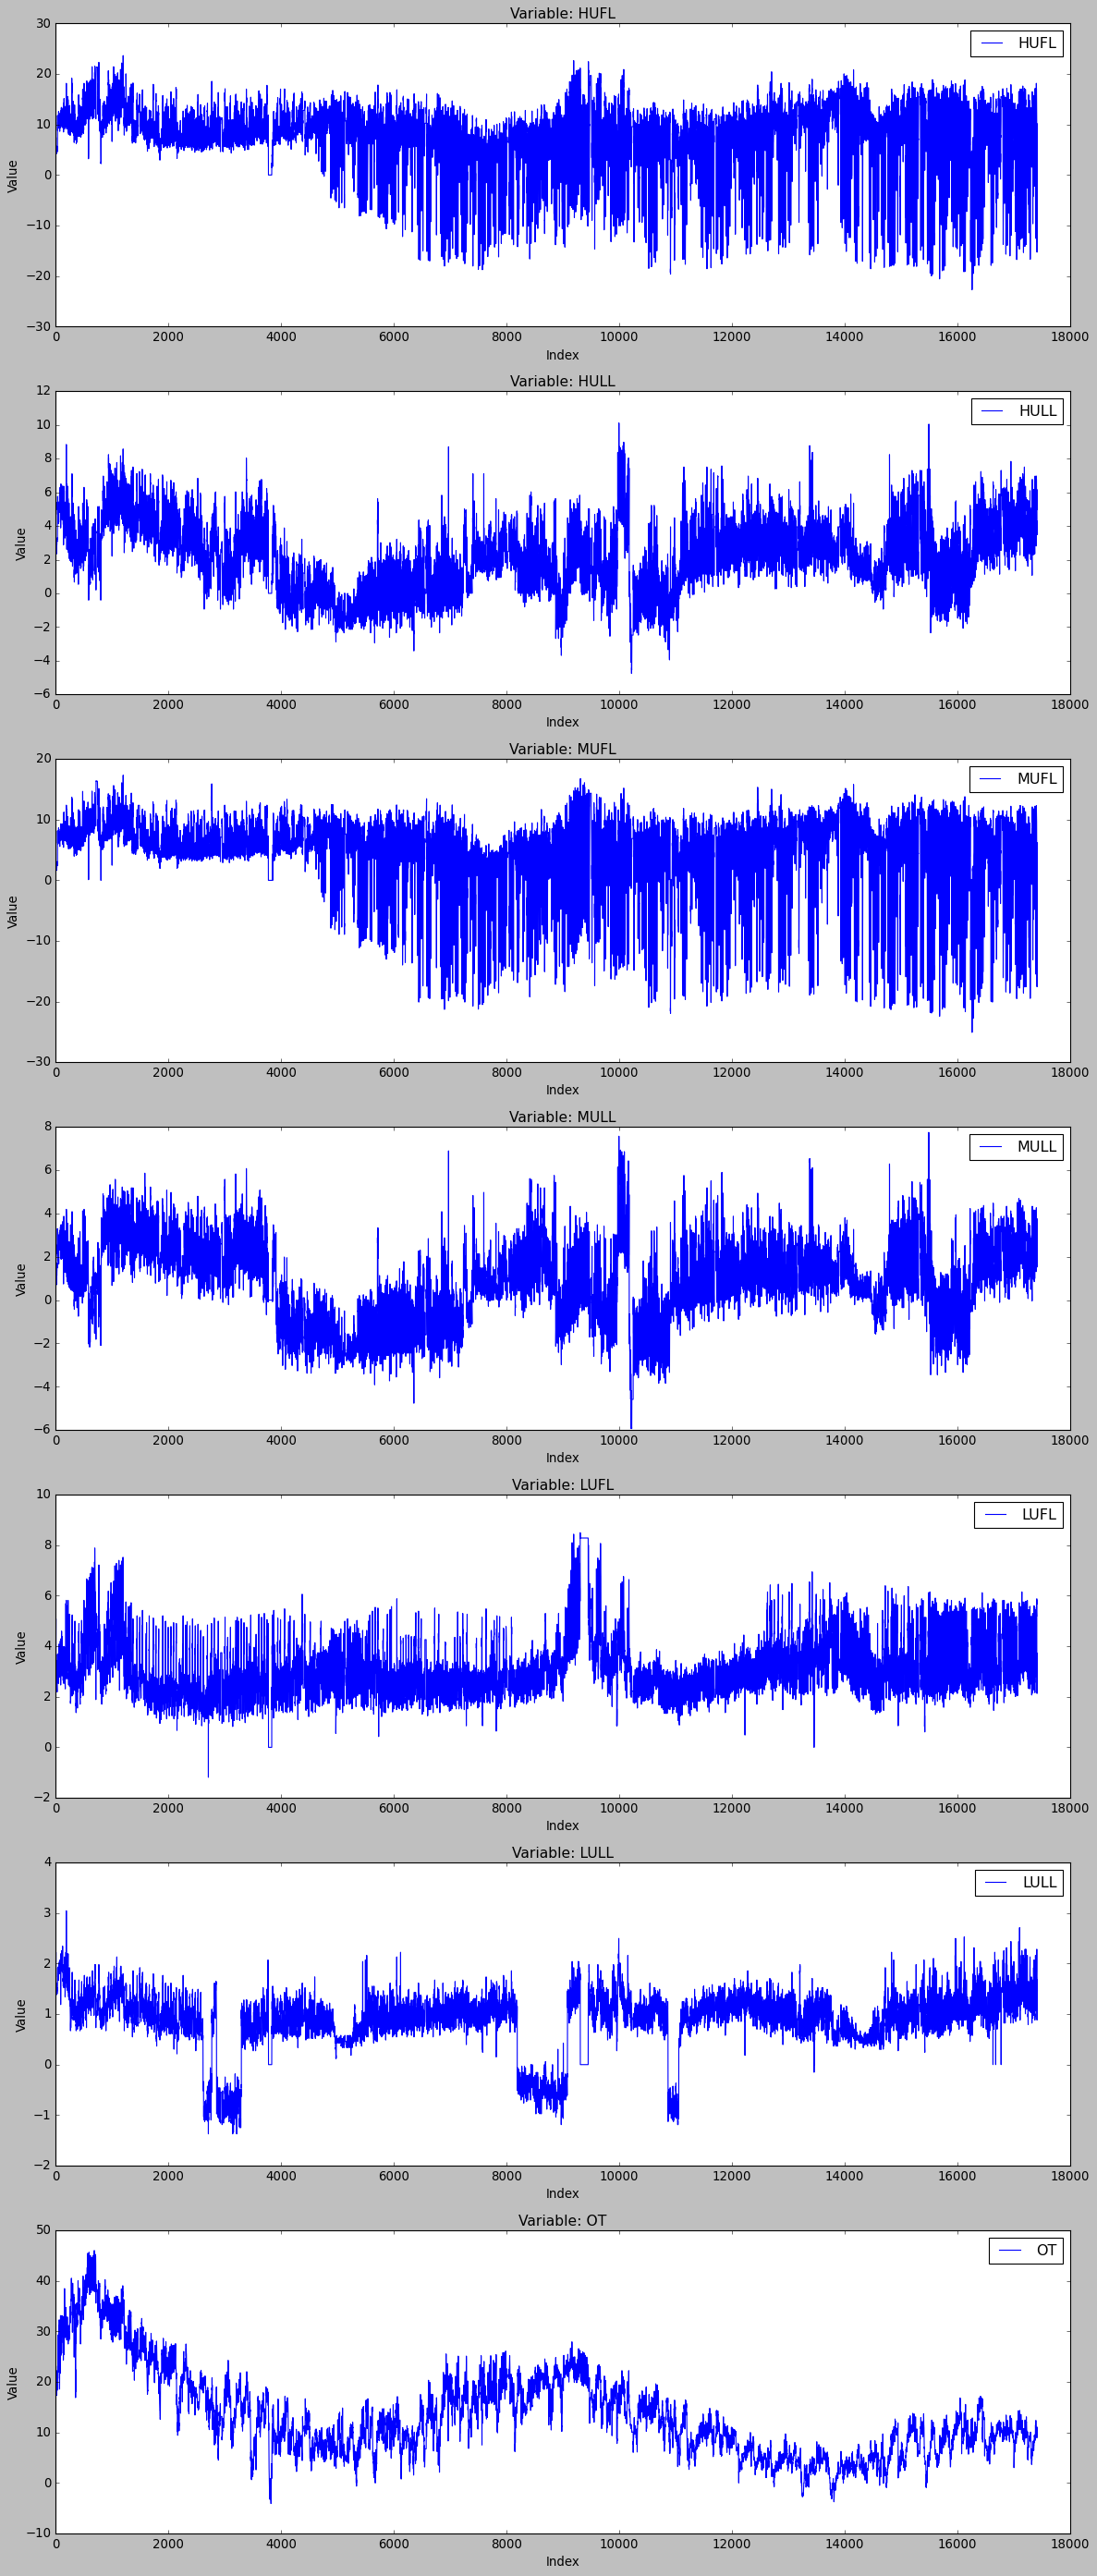

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_data_from_csv(file_path):
    # Load data
    data = pd.read_csv(file_path)
    print("Columns in the dataset:", data.columns.tolist())

    # Ask user for input on which columns to plot as variables
    var_columns = input("Enter the column names or indices for variables, separated by commas (e.g., var1, var2, var3): ")
    var_columns = [x.strip() for x in var_columns.split(',')]
    
    # Check if columns are specified by index and convert if necessary
    if var_columns[0].isdigit():
        var_columns = [data.columns[int(i)] for i in var_columns]

    # Check if the data includes a label (ground truth)
    is_labeled = input("Does the dataset include labels? (yes/no): ").lower() == 'yes'
    label_column = None
    if is_labeled:
        label_column = input("Enter the column name for the label: ").strip()

    # Plot settings
    plt.style.use('classic')
    fig, axs = plt.subplots(len(var_columns), 1, figsize=(15, 5 * len(var_columns)))

    for idx, var in enumerate(var_columns):
        ax = axs[idx] if len(var_columns) > 1 else axs
        ax.plot(data.index, data[var], label=f'{var}')
        ax.set_title(f'Variable: {var}', fontsize=14)
        ax.set_ylabel('Value', fontsize=12)
        ax.set_xlabel('Index', fontsize=12)
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    file_path = input("Enter the path to your CSV file: ")
    plot_data_from_csv(file_path)


In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd

user_inputs = {}

def select_file():
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    if file_path:
        user_inputs['file_path'] = file_path
        file_label.config(text=file_path.split("/")[-1])
        try:
            df = pd.read_csv(file_path)
            user_inputs['columns'] = df.columns.tolist()
            user_inputs['n_rows'] = len(df)
            print("[INFO] File Loaded:", file_path)
            print("[INFO] Columns:", df.columns.tolist())
            print("[INFO] First 5 rows:\n", df.head().to_string(index=False))
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read CSV: {e}")
            return
    else:
        file_label.config(text="No file selected")

def on_submit():
    try:
        user_inputs['first_col_index'] = int(first_col_entry.get())
        user_inputs['last_col_index'] = int(last_col_entry.get())
        user_inputs['window_size'] = int(window_entry.get())
        user_inputs['slide_size'] = int(slide_entry.get())
        user_inputs['has_state_column'] = state_var.get()
        user_inputs['state_column'] = state_col_entry.get() if state_var.get() else None

        print("\n User Inputs:")
        for k, v in user_inputs.items():
            print(f"{k}: {v}")

        messagebox.showinfo("Success", "Inputs collected successfully!")
    except Exception as e:
        messagebox.showerror("Error", f"Invalid input: {e}")

# --- GUI Setup ---
window = tk.Tk()
window.title("CSV Input GUI")
window.geometry("500x400")

tk.Label(window, text="Step 1: Load CSV File").pack(pady=(10,0))
tk.Button(window, text="Browse CSV", command=select_file).pack()
file_label = tk.Label(window, text="No file selected", fg="gray")
file_label.pack(pady=5)

tk.Label(window, text="Step 2: Specify Parameters").pack(pady=10)

form_frame = tk.Frame(window)
form_frame.pack(pady=5)

tk.Label(form_frame, text="First column index to plot:").grid(row=0, column=0, sticky="e")
first_col_entry = tk.Entry(form_frame, width=10)
first_col_entry.grid(row=0, column=1)

tk.Label(form_frame, text="Last column index to plot:").grid(row=1, column=0, sticky="e")
last_col_entry = tk.Entry(form_frame, width=10)
last_col_entry.grid(row=1, column=1)

tk.Label(form_frame, text="Window size:").grid(row=2, column=0, sticky="e")
window_entry = tk.Entry(form_frame, width=10)
window_entry.grid(row=2, column=1)

tk.Label(form_frame, text="Sliding factor:").grid(row=3, column=0, sticky="e")
slide_entry = tk.Entry(form_frame, width=10)
slide_entry.grid(row=3, column=1)

state_var = tk.BooleanVar()
state_checkbox = tk.Checkbutton(form_frame, text="Dataset has a state column", variable=state_var)
state_checkbox.grid(row=4, column=0, columnspan=2, pady=(10,0))

tk.Label(form_frame, text="State column name:").grid(row=5, column=0, sticky="e")
state_col_entry = tk.Entry(form_frame, width=10)
state_col_entry.grid(row=5, column=1)

tk.Button(window, text="Submit", command=on_submit, bg="lightgreen").pack(pady=15)

window.mainloop()



 User Inputs:
first_col_index: 1
last_col_index: 2
window_size: 23
slide_size: 23
has_state_column: False
state_column: None


[INFO] File Loaded: C:/Users/adnan/work_2025/DRUM/data1.csv


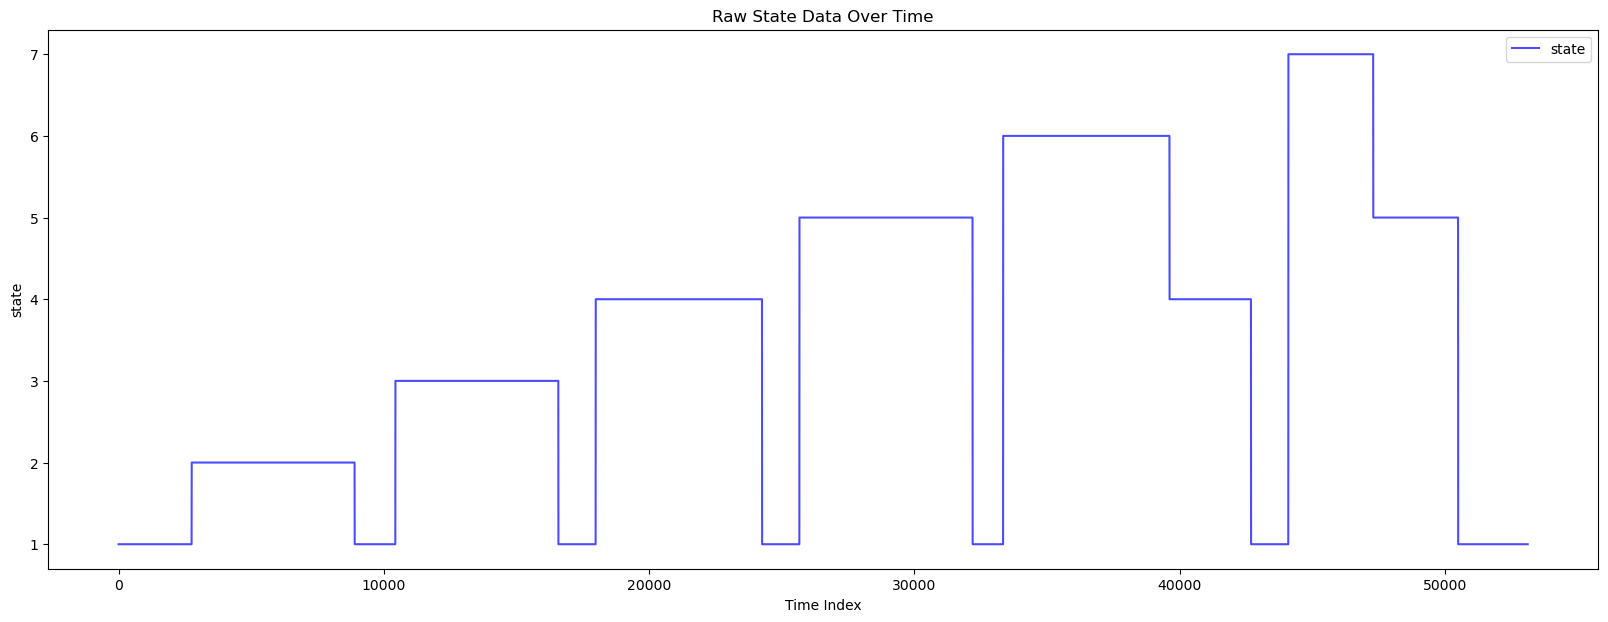

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Default settings for visualization
DEFAULT_FIG_SIZE = (20, 7)
DEFAULT_DPI = 100

# Data processing parameters
WINDOW_SIZE = 50
SLIDE_SIZE = 20

# Plot customization options
COLOR_STATE = 'blue'
COLOR_LCS_SCORE = 'tab:red'
COLOR_CHANGE_POINT = 'red'

# Text and label customization
LABEL_STATE = 'state'
LABEL_LCS_SCORE = 'DRUM Score'
TITLE_RAW_DATA = 'Raw State Data Over Time'
TITLE_SEGMENTED_DATA = 'State Data Segmented into Windows'
TITLE_STATE_PER_WINDOW = 'State per Window'
TITLE_LCS_SCORE = 'LCS Score for Window Size'
TITLE_LCS_AND_STATE = 'DRUM Score and State per Window'

user_inputs = {}

# Function to load data
def load_data(file_path):
    return pd.read_csv(file_path)

# Function to visualize raw data
def plot_raw_data(data):
    plt.figure(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)
    plt.plot(data.index, data[LABEL_STATE], label=LABEL_STATE, color=COLOR_STATE, alpha=0.7)
    plt.xlabel('Time Index')
    plt.ylabel(LABEL_STATE)
    plt.title(TITLE_RAW_DATA)
    plt.legend()
    plt.show()

# Function to segment data into windows
def segment_data(data, window_size=WINDOW_SIZE, slide_size=SLIDE_SIZE):
    windows = []
    start_idx = 0
    while start_idx + window_size <= len(data):
        windows.append(data.iloc[start_idx:start_idx + window_size])
        start_idx += slide_size
    return windows

# Function to plot segmented windows
def plot_windows(windows):
    plt.figure(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)
    for i, window in enumerate(windows):
        plt.plot(window.index, window[LABEL_STATE], label=f'Window {i}', alpha=0.5)
    plt.xlabel('Time Index')
    plt.ylabel(LABEL_STATE)
    plt.title(TITLE_SEGMENTED_DATA.replace("Windows", f"Windows of Size {WINDOW_SIZE}"))
    plt.legend()
    plt.show()

# Function to calculate LCS for windows
def calculate_lcs(windows):
    lcs_scores = []
    majority_states = []

    for i in tqdm(range(len(windows)), desc='Calculating LCS for windows'):
        window = windows[i]
        majority_state = window[LABEL_STATE].mode()[0]
        majority_states.append(majority_state)

        if i > 0:
            prev_window = windows[i-1]
            delta_m = np.abs(window.mean() - prev_window.mean())
            delta_s = np.abs(window.std() - prev_window.std())
            delta_frm = np.zeros(len(window.columns) - 2)
            for j, col in enumerate(window.columns[:-2]):
                running_mean = window[col].rolling(window=len(window), min_periods=1).mean()
                prev_running_mean = prev_window[col].rolling(window=len(prev_window), min_periods=1).mean()
                intersections_current = count_intersections(window[col].values, running_mean.values)
                intersections_previous = count_intersections(prev_window[col].values, prev_running_mean.values)
                delta_frm[j] = np.abs(intersections_current - intersections_previous)

            lcs = (1/3) * delta_m.sum() + (1/3) * delta_s.sum() + (1/3) * delta_frm.sum()
            lcs_scores.append(lcs)
        else:
            lcs_scores.append(None)  # First window has no previous window to compare with

    # Normalize LCS scores
    valid_lcs_scores = [x for x in lcs_scores if x is not None]
    min_lcs = min(valid_lcs_scores) if valid_lcs_scores else 0
    max_lcs = max(valid_lcs_scores) if valid_lcs_scores else 1
    normalized_lcs = [(x - min_lcs) / (max_lcs - min_lcs) if x is not None else None for x in lcs_scores]

    return pd.DataFrame({
        'Window Index': range(len(windows)),
        'LCS Score': normalized_lcs,
        'Majority State': majority_states
    })

# Function to find state change points
def find_state_change_points(majority_states):
    change_points = []
    for i in range(1, len(majority_states)):
        if majority_states[i] != majority_states[i-1]:
            change_points.append(i)  # Store the index of the window where the change occurs
    return change_points
    
def count_intersections(data, running_mean):
    intersections = 0
    for i in range(1, len(data)):
        if (data[i-1] > running_mean[i-1] and data[i] <= running_mean[i]) or \
           (data[i-1] < running_mean[i-1] and data[i] >= running_mean[i]):
            intersections += 1
    return intersections

# Function to plot LCS scores with state changes
def plot_lcs(lcs_results, change_points):
    plt.figure(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)
    plt.plot(lcs_results['Window Index'], lcs_results['LCS Score'], label=LABEL_LCS_SCORE, color=COLOR_LCS_SCORE)
    for cp in change_points:
        plt.axvline(x=cp, color=COLOR_CHANGE_POINT, linestyle='dashed', alpha=0.6)
    plt.xlabel('Window Index')
    plt.ylabel(LABEL_LCS_SCORE)
    plt.title(TITLE_LCS_SCORE.replace("Window Size", f"Window Size {WINDOW_SIZE} with State Changes"))
    plt.legend()
    plt.show()

# Function to plot per window state
def plot_window_states(windows):
    states = [window[LABEL_STATE].mode()[0] for window in windows]
    plt.figure(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)
    plt.plot(range(len(states)), states, marker='o', linestyle='-', color=COLOR_STATE, alpha=0.7)
    plt.xlabel('Window Index')
    plt.ylabel(LABEL_STATE)
    plt.title(TITLE_STATE_PER_WINDOW.replace("Window", f"Window (Size {WINDOW_SIZE})"))
    plt.grid(True)
    plt.show()

# Function to plot LCS score and majority state per window in one plot
def plot_lcs_and_states(lcs_results, windows):
    states = [window[LABEL_STATE].mode()[0] for window in windows]

    fig, ax1 = plt.subplots(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)

    # Plot LCS scores on the left y-axis
    ax1.set_xlabel('Window Index')
    ax1.set_ylabel(LABEL_LCS_SCORE, color=COLOR_LCS_SCORE)
    ax1.plot(lcs_results['Window Index'], lcs_results['LCS Score'], color=COLOR_LCS_SCORE, linestyle='-')
    ax1.tick_params(axis='y', labelcolor=COLOR_LCS_SCORE)

    # Create a second y-axis for state values
    ax2 = ax1.twinx()
    ax2.set_ylabel(LABEL_STATE, color=COLOR_STATE)
    ax2.plot(range(len(states)), states, color=COLOR_STATE, marker='s', linestyle='--', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=COLOR_STATE)

    plt.title(TITLE_LCS_AND_STATE.replace("Window", f"Window (Size {WINDOW_SIZE})"))
    plt.show()

# Function to handle CSV file selection
def select_file():
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    if file_path:
        user_inputs['file_path'] = file_path
        file_label.config(text=file_path.split("/")[-1])
        try:
            data = pd.read_csv(file_path)
            user_inputs['columns'] = data.columns.tolist()
            user_inputs['n_rows'] = len(data)
            display_data(data.head())  # Display the first 5 rows of the CSV
            print("[INFO] File Loaded:", file_path)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read CSV: {e}")
            return
    else:
        file_label.config(text="No file selected")

# Function to display the first 5 rows in the GUI
def display_data(data):
    preview_text = data.head().to_string(index=True)
    data_preview_label.config(text="First 5 Rows of Data")
    data_preview_text.config(state=tk.NORMAL)
    data_preview_text.delete(1.0, tk.END)
    data_preview_text.insert(tk.END, preview_text)
    data_preview_text.config(state=tk.DISABLED)

# Function to handle input collection and visualization
def on_submit():
    try:
        user_inputs['first_col_index'] = int(first_col_entry.get()) - 1  # Convert to 0-based index
        user_inputs['last_col_index'] = int(last_col_entry.get()) - 1  # Convert to 0-based index
        user_inputs['window_size'] = int(window_entry.get())
        user_inputs['slide_size'] = int(slide_entry.get())
        user_inputs['has_state_column'] = state_var.get()
        user_inputs['state_column'] = state_col_entry.get() if state_var.get() else None

        # Load the data and segment it
        data = load_data(user_inputs['file_path'])
        windows = segment_data(data, user_inputs['window_size'], user_inputs['slide_size'])
        
        # Plot the data
        plot_raw_data(data)
        plot_windows(windows)
        
        # Calculate LCS scores and plot
        lcs_results = calculate_lcs(windows)
        majority_states = lcs_results['Majority State'].tolist()
        change_points = find_state_change_points(majority_states)
        
        plot_lcs(lcs_results, change_points)
        plot_window_states(windows)
        plot_lcs_and_states(lcs_results, windows)
        
        # Close the Tkinter GUI window
        window.quit()

        # Output results in the notebook
        print("\n User Inputs:")
        for k, v in user_inputs.items():
            print(f"{k}: {v}")
        messagebox.showinfo("Success", "Inputs collected and visualizations generated successfully!")
    except Exception as e:
        messagebox.showerror("Error", f"Invalid input: {e}")

# Function to close GUI and proceed to Jupyter Notebook
def close_gui_and_proceed():
    # Call on_submit to save inputs and close the GUI
    on_submit()
    window.quit()  # Close the GUI window

# --- GUI Setup ---
window = tk.Tk()
window.title("CSV Input GUI")
window.geometry("600x600")

tk.Label(window, text="Step 1: Load CSV File").pack(pady=(10,0))
tk.Button(window, text="Browse CSV", command=select_file).pack()
file_label = tk.Label(window, text="No file selected", fg="gray")
file_label.pack(pady=5)

tk.Label(window, text="Step 2: Specify Parameters").pack(pady=10)

form_frame = tk.Frame(window)
form_frame.pack(pady=5)

tk.Label(form_frame, text="First column index to plot:").grid(row=0, column=0, sticky="e")
first_col_entry = tk.Entry(form_frame, width=10)
first_col_entry.grid(row=0, column=1)

tk.Label(form_frame, text="Last column index to plot:").grid(row=1, column=0, sticky="e")
last_col_entry = tk.Entry(form_frame, width=10)
last_col_entry.grid(row=1, column=1)

tk.Label(form_frame, text="Window size:").grid(row=2, column=0, sticky="e")
window_entry = tk.Entry(form_frame, width=10)
window_entry.grid(row=2, column=1)

tk.Label(form_frame, text="Sliding factor:").grid(row=3, column=0, sticky="e")
slide_entry = tk.Entry(form_frame, width=10)
slide_entry.grid(row=3, column=1)

state_var = tk.BooleanVar()
state_checkbox = tk.Checkbutton(form_frame, text="Dataset has a state column", variable=state_var)
state_checkbox.grid(row=4, column=0, columnspan=2, pady=(10,0))

tk.Label(form_frame, text="State column name:").grid(row=5, column=0, sticky="e")
state_col_entry = tk.Entry(form_frame, width=10)
state_col_entry.grid(row=5, column=1)

# Add button to close the GUI and proceed
tk.Button(window, text="Submit & Close", command=close_gui_and_proceed, bg="lightgreen").pack(pady=15)

# Adding text widget for displaying first 5 rows
data_preview_label = tk.Label(window, text="Data Preview")
data_preview_label.pack(pady=5)
data_preview_text = tk.Text(window, height=10, width=120)
data_preview_text.pack(pady=5)
data_preview_text.config(state=tk.DISABLED)

window.mainloop()


In [5]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd

# Initialize the variables with default values
user_inputs = {
    "file_path": "",
    "first_col_index": None,
    "last_col_index": None,
    "window_size": 50,
    "slide_size": 20,
    "has_state_column": False,
    "state_column": None
}

# Default settings for visualization
DEFAULT_FIG_SIZE = (20,7)
DEFAULT_DPI = 100

# Data processing parameters (These will be updated based on user input)
WINDOW_SIZE = 50
SLIDE_SIZE = 20

# Plot customization options
COLOR_STATE = 'blue'
COLOR_LCS_SCORE = 'tab:red'
COLOR_CHANGE_POINT = 'red'

# Text and label customization
LABEL_STATE = 'state'
LABEL_LCS_SCORE = 'DRUM Score'
TITLE_RAW_DATA = 'Raw State Data Over Time'
TITLE_SEGMENTED_DATA = 'State Data Segmented into Windows'
TITLE_STATE_PER_WINDOW = 'State per Window'
TITLE_LCS_SCORE = 'LCS Score for Window Size'
TITLE_LCS_AND_STATE = 'DRUM Score and State per Window'

num_vars = 9  # Since you have 9 variables to plot
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']  # One color for each variable

# Function to handle CSV file selection
def select_file():
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    if file_path:
        user_inputs['file_path'] = file_path
        file_label.config(text=file_path.split("/")[-1])
        try:
            data = pd.read_csv(file_path)
            user_inputs['columns'] = data.columns.tolist()
            user_inputs['n_rows'] = len(data)
            display_data(data)  # Display the first 5 rows of the CSV
            print("[INFO] File Loaded:", file_path)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read CSV: {e}")
            return
    else:
        file_label.config(text="No file selected")

# Function to display the first 5 rows in the GUI
def display_data(data):
    # Add a row with column numbers starting from 1
    col_numbers = ['Col #' + str(i + 1) for i in range(len(data.columns))]
    data_with_index = pd.concat([pd.DataFrame([col_numbers], columns=data.columns), data.head()], ignore_index=True)
    preview_text = data_with_index.to_string(index=False)
    
    data_preview_label.config(text="First 5 Rows of Data (Column Numbers on Top)")
    data_preview_text.config(state=tk.NORMAL)
    data_preview_text.delete(1.0, tk.END)
    data_preview_text.insert(tk.END, preview_text)
    data_preview_text.config(state=tk.DISABLED)

# Function to handle input collection
def on_submit():
    try:
        user_inputs['first_col_index'] = int(first_col_entry.get()) - 1  # Convert to 0-based index
        user_inputs['last_col_index'] = int(last_col_entry.get()) - 1  # Convert to 0-based index
        user_inputs['window_size'] = int(window_entry.get())
        user_inputs['slide_size'] = int(slide_entry.get())
        user_inputs['has_state_column'] = state_var.get()
        user_inputs['state_column'] = state_col_entry.get() if state_var.get() else None

        # Close the Tkinter GUI window
        window.destroy()  # Properly close the GUI

        messagebox.showinfo("Success", "Inputs collected successfully!")
        print("\n User Inputs:")
        for k, v in user_inputs.items():
            print(f"{k}: {v}")
    except Exception as e:
        messagebox.showerror("Error", f"Invalid input: {e}")

# --- GUI Setup ---
window = tk.Tk()
window.title("CSV Input GUI")
window.geometry("600x400")

tk.Label(window, text="Step 1: Load CSV File").pack(pady=(10,0))
tk.Button(window, text="Browse CSV", command=select_file).pack()
file_label = tk.Label(window, text="No file selected", fg="gray")
file_label.pack(pady=5)

tk.Label(window, text="Step 2: Specify Parameters").pack(pady=10)

form_frame = tk.Frame(window)
form_frame.pack(pady=5)

tk.Label(form_frame, text="First column index to plot:").grid(row=0, column=0, sticky="e")
first_col_entry = tk.Entry(form_frame, width=10)
first_col_entry.grid(row=0, column=1)

tk.Label(form_frame, text="Last column index to plot:").grid(row=1, column=0, sticky="e")
last_col_entry = tk.Entry(form_frame, width=10)
last_col_entry.grid(row=1, column=1)

tk.Label(form_frame, text="Window size:").grid(row=2, column=0, sticky="e")
window_entry = tk.Entry(form_frame, width=10)
window_entry.grid(row=2, column=1)

tk.Label(form_frame, text="Sliding factor:").grid(row=3, column=0, sticky="e")
slide_entry = tk.Entry(form_frame, width=10)
slide_entry.grid(row=3, column=1)

state_var = tk.BooleanVar()
state_checkbox = tk.Checkbutton(form_frame, text="Dataset has a state column", variable=state_var)
state_checkbox.grid(row=4, column=0, columnspan=2, pady=(10,0))

tk.Label(form_frame, text="State column name:").grid(row=5, column=0, sticky="e")
state_col_entry = tk.Entry(form_frame, width=10)
state_col_entry.grid(row=5, column=1)

# Add button to close the GUI and proceed
tk.Button(window, text="Submit & Close", command=on_submit, bg="lightgreen").pack(pady=15)

# Adding text widget for displaying first 5 rows
data_preview_label = tk.Label(window, text="Data Preview")
data_preview_label.pack(pady=5)
data_preview_text = tk.Text(window, height=10, width=70)
data_preview_text.pack(pady=5)
data_preview_text.config(state=tk.DISABLED)

window.mainloop()


[INFO] File Loaded: C:/Users/adnan/work_2025/DRUM/data1.csv

 User Inputs:
file_path: C:/Users/adnan/work_2025/DRUM/data1.csv
first_col_index: 0
last_col_index: 8
window_size: 20
slide_size: 20
has_state_column: True
state_column: 11
columns: ['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'state', 'time_stamp']
n_rows: 53120


In [14]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd

# Global variables for visualization settings
WINDOW_SIZE = 50
SLIDE_SIZE = 20
LABEL_STATE = 'state'
LABEL_LCS_SCORE = 'DRUM Score'
TITLE_RAW_DATA = 'Raw State Data Over Time'
TITLE_SEGMENTED_DATA = 'State Data Segmented into Windows'
TITLE_STATE_PER_WINDOW = 'State per Window'
TITLE_LCS_SCORE = 'LCS Score for Window Size'
TITLE_LCS_AND_STATE = 'DRUM Score and State per Window'

user_inputs = {
    "file_path": "",
    "first_col_index": None,
    "last_col_index": None,
    "window_size": 50,
    "slide_size": 20,
    "has_state_column": False,
    "state_column": None
}


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to load data
def load_data(file_path):
    return pd.read_csv(file_path)

# # Function to visualize raw data
# def plot_raw_data(data):
#     plt.figure(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)
#     plt.plot(data.index, data[LABEL_STATE], label=LABEL_STATE, color=COLOR_STATE, alpha=0.7)
#     plt.xlabel('Time Index')
#     plt.ylabel(LABEL_STATE)
#     plt.title(TITLE_RAW_DATA)
#     plt.legend()
#     plt.show()
# Function to visualize raw data
def plot_raw_data(data):
    # Check if the state column exists in the data
    if LABEL_STATE not in data.columns:
        print(f"Error: '{LABEL_STATE}' column not found in the data.")
        return  # Exit if the column doesn't exist
    
    plt.figure(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)
    plt.plot(data.index, data[LABEL_STATE], label=LABEL_STATE, color=COLOR_STATE, alpha=0.7)
    plt.xlabel('Time Index')
    plt.ylabel(LABEL_STATE)
    plt.title(TITLE_RAW_DATA)
    plt.legend()
    plt.show()

# Example: If LABEL_STATE is set based on user input, ensure it's valid
if user_inputs['has_state_column']:
    LABEL_STATE = user_inputs['state_column']  # Use user input for state column
else:
    LABEL_STATE = 'state'  # Default state column name

# Function to segment data into windows
def segment_data(data, window_size=WINDOW_SIZE, slide_size=SLIDE_SIZE):
    windows = []
    start_idx = 0
    while start_idx + window_size <= len(data):
        windows.append(data.iloc[start_idx:start_idx + window_size])
        start_idx += slide_size
    return windows

# Function to plot segmented windows
def plot_windows(windows):
    plt.figure(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)
    for i, window in enumerate(windows):
        plt.plot(window.index, window[LABEL_STATE], label=f'Window {i}', alpha=0.5)
    plt.xlabel('Time Index')
    plt.ylabel(LABEL_STATE)
    plt.title(TITLE_SEGMENTED_DATA.replace("Windows", f"Windows of Size {WINDOW_SIZE}"))
    plt.legend()
    plt.show()

# Function to calculate LCS for windows
def calculate_lcs(windows):
    lcs_scores = []
    majority_states = []

    for i in tqdm(range(len(windows)), desc='Calculating LCS for windows'):
        window = windows[i]
        majority_state = window[LABEL_STATE].mode()[0]
        majority_states.append(majority_state)

        if i > 0:
            prev_window = windows[i-1]
            delta_m = np.abs(window.mean() - prev_window.mean())
            delta_s = np.abs(window.std() - prev_window.std())
            delta_frm = np.zeros(len(window.columns) - 2)
            for j, col in enumerate(window.columns[:-2]):
                running_mean = window[col].rolling(window=len(window), min_periods=1).mean()
                prev_running_mean = prev_window[col].rolling(window=len(prev_window), min_periods=1).mean()
                intersections_current = count_intersections(window[col].values, running_mean.values)
                intersections_previous = count_intersections(prev_window[col].values, prev_running_mean.values)
                delta_frm[j] = np.abs(intersections_current - intersections_previous)

            lcs = (1/3) * delta_m.sum() + (1/3) * delta_s.sum() + (1/3) * delta_frm.sum()
            lcs_scores.append(lcs)
        else:
            lcs_scores.append(None)  # First window has no previous window to compare with

    # Normalize LCS scores
    valid_lcs_scores = [x for x in lcs_scores if x is not None]
    min_lcs = min(valid_lcs_scores) if valid_lcs_scores else 0
    max_lcs = max(valid_lcs_scores) if valid_lcs_scores else 1
    normalized_lcs = [(x - min_lcs) / (max_lcs - min_lcs) if x is not None else None for x in lcs_scores]

    return pd.DataFrame({
        'Window Index': range(len(windows)),
        'LCS Score': normalized_lcs,
        'Majority State': majority_states
    })

# Function to find state change points
def find_state_change_points(majority_states):
    change_points = []
    for i in range(1, len(majority_states)):
        if majority_states[i] != majority_states[i-1]:
            change_points.append(i)  # Store the index of the window where the change occurs
    return change_points
    
def count_intersections(data, running_mean):
    intersections = 0
    for i in range(1, len(data)):
        if (data[i-1] > running_mean[i-1] and data[i] <= running_mean[i]) or \
           (data[i-1] < running_mean[i-1] and data[i] >= running_mean[i]):
            intersections += 1
    return intersections

# Function to plot LCS scores with state changes
def plot_lcs(lcs_results, change_points):
    plt.figure(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)
    plt.plot(lcs_results['Window Index'], lcs_results['LCS Score'], label=LABEL_LCS_SCORE, color=COLOR_LCS_SCORE)
    for cp in change_points:
        plt.axvline(x=cp, color=COLOR_CHANGE_POINT, linestyle='dashed', alpha=0.6)
    plt.xlabel('Window Index')
    plt.ylabel(LABEL_LCS_SCORE)
    plt.title(TITLE_LCS_SCORE.replace("Window Size", f"Window Size {WINDOW_SIZE} with State Changes"))
    plt.legend()
    plt.show()

# Function to plot per window state
def plot_window_states(windows):
    states = [window[LABEL_STATE].mode()[0] for window in windows]
    plt.figure(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)
    plt.plot(range(len(states)), states, marker='o', linestyle='-', color=COLOR_STATE, alpha=0.7)
    plt.xlabel('Window Index')
    plt.ylabel(LABEL_STATE)
    plt.title(TITLE_STATE_PER_WINDOW.replace("Window", f"Window (Size {WINDOW_SIZE})"))
    plt.grid(True)
    plt.show()

# Function to plot LCS score and majority state per window in one plot
def plot_lcs_and_states(lcs_results, windows):
    states = [window[LABEL_STATE].mode()[0] for window in windows]

    fig, ax1 = plt.subplots(figsize=DEFAULT_FIG_SIZE, dpi=DEFAULT_DPI)

    # Plot LCS scores on the left y-axis
    ax1.set_xlabel('Window Index')
    ax1.set_ylabel(LABEL_LCS_SCORE, color=COLOR_LCS_SCORE)
    ax1.plot(lcs_results['Window Index'], lcs_results['LCS Score'], color=COLOR_LCS_SCORE, linestyle='-')
    ax1.tick_params(axis='y', labelcolor=COLOR_LCS_SCORE)

    # Create a second y-axis for state values
    ax2 = ax1.twinx()
    ax2.set_ylabel(LABEL_STATE, color=COLOR_STATE)
    ax2.plot(range(len(states)), states, color=COLOR_STATE, marker='s', linestyle='--', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=COLOR_STATE)

    plt.title(TITLE_LCS_AND_STATE.replace("Window", f"Window (Size {WINDOW_SIZE})"))
    #fig.tight_layout()
    plt.show()


def plot_variables(file_path, num_vars, colors):
    """
    Plots multiple variables from a CSV file.

    Parameters:
    file_path (str): The path to the CSV file.
    num_vars (int): Number of variables to plot.
    colors (list): List of colors for each plot.
    """
    plt.style.use('classic')  # Set the plotting style
    data = pd.read_csv(file_path)  # Load data
    
    # Check if the number of colors and number of variables match
    if len(colors) < num_vars:
        raise ValueError("Number of colors provided is less than the number of variables to plot.")

    fig, axs = plt.subplots(num_vars, 1, figsize=(20, 2*num_vars))  # Adjust subplot arrangement and size

    for i in range(num_vars):
        ax = axs[i] if num_vars > 1 else axs  # Handle the case for a single subplot
        var_name = f'var{i+1}'
        if var_name not in data.columns:
            raise ValueError(f"{var_name} not found in the data.")
        ax.plot(data[var_name], color=colors[i], label=var_name)
        ax.set_title(f'Variable {i+1}', fontsize=14)
        ax.set_ylabel('Value', fontsize=12)
        ax.set_xlabel('Index', fontsize=12)
        ax.legend(loc='upper right')

    plt.tight_layout()  # Optimize layout
    plt.show()

# Function to handle CSV file selection
def select_file():
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    if file_path:
        user_inputs['file_path'] = file_path
        file_label.config(text=file_path.split("/")[-1])
        try:
            data = pd.read_csv(file_path)
            user_inputs['columns'] = data.columns.tolist()
            user_inputs['n_rows'] = len(data)
            display_data(data)  # Display the first 5 rows of the CSV
            print("[INFO] File Loaded:", file_path)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read CSV: {e}")
            return
    else:
        file_label.config(text="No file selected")

# Function to display the first 5 rows in the GUI
def display_data(data):
    # Add a row with column numbers starting from 1
    col_numbers = ['Col #' + str(i + 1) for i in range(len(data.columns))]
    data_with_index = pd.concat([pd.DataFrame([col_numbers], columns=data.columns), data.head()], ignore_index=True)
    preview_text = data_with_index.to_string(index=False)
    
    data_preview_label.config(text="First 5 Rows of Data (Column Numbers on Top)")
    data_preview_text.config(state=tk.NORMAL)
    data_preview_text.delete(1.0, tk.END)
    data_preview_text.insert(tk.END, preview_text)
    data_preview_text.config(state=tk.DISABLED)

# Function to handle input collection
def on_submit():
    try:
        user_inputs['first_col_index'] = int(first_col_entry.get()) - 1  # Convert to 0-based index
        user_inputs['last_col_index'] = int(last_col_entry.get()) - 1  # Convert to 0-based index
        user_inputs['window_size'] = int(window_entry.get())
        user_inputs['slide_size'] = int(slide_entry.get())
        user_inputs['has_state_column'] = state_var.get()
        user_inputs['state_column'] = state_col_entry.get() if state_var.get() else None

        # Update global variables based on user inputs
        global WINDOW_SIZE, SLIDE_SIZE, LABEL_STATE, LABEL_LCS_SCORE
        WINDOW_SIZE = user_inputs['window_size']
        SLIDE_SIZE = user_inputs['slide_size']
        LABEL_STATE = user_inputs['state_column'] if user_inputs['has_state_column'] else 'state'
        LABEL_LCS_SCORE = 'DRUM Score'

        # Close the Tkinter GUI window
        window.destroy()  # Properly close the GUI

        messagebox.showinfo("Success", "Inputs collected successfully!")
        print("\n User Inputs:")
        for k, v in user_inputs.items():
            print(f"{k}: {v}")
    except Exception as e:
        messagebox.showerror("Error", f"Invalid input: {e}")

In [16]:


# --- GUI Setup ---
window = tk.Tk()
window.title("CSV Input GUI")
window.geometry("1200x700")  # Adjusted dialog size

tk.Label(window, text="Step 1: Load CSV File").pack(pady=(10,0))
tk.Button(window, text="Browse CSV", command=select_file).pack()
file_label = tk.Label(window, text="No file selected", fg="gray")
file_label.pack(pady=5)

tk.Label(window, text="Step 2: Specify Parameters").pack(pady=10)

form_frame = tk.Frame(window)
form_frame.pack(pady=5)

tk.Label(form_frame, text="First column index to plot:").grid(row=0, column=0, sticky="e")
first_col_entry = tk.Entry(form_frame, width=10)
first_col_entry.grid(row=0, column=1)

tk.Label(form_frame, text="Last column index to plot:").grid(row=1, column=0, sticky="e")
last_col_entry = tk.Entry(form_frame, width=10)
last_col_entry.grid(row=1, column=1)

tk.Label(form_frame, text="Window size:").grid(row=2, column=0, sticky="e")
window_entry = tk.Entry(form_frame, width=10)
window_entry.grid(row=2, column=1)

tk.Label(form_frame, text="Sliding factor:").grid(row=3, column=0, sticky="e")
slide_entry = tk.Entry(form_frame, width=10)
slide_entry.grid(row=3, column=1)

state_var = tk.BooleanVar()
state_checkbox = tk.Checkbutton(form_frame, text="Dataset has a state column", variable=state_var)
state_checkbox.grid(row=4, column=0, columnspan=2, pady=(10,0))

tk.Label(form_frame, text="State column name:").grid(row=5, column=0, sticky="e")
state_col_entry = tk.Entry(form_frame, width=10)
state_col_entry.grid(row=5, column=1)

# Add button to close the GUI and proceed
tk.Button(window, text="Submit & Close", command=on_submit, bg="lightgreen").pack(pady=15)

# Adding text widget for displaying first 5 rows
data_preview_label = tk.Label(window, text="Data Preview")
data_preview_label.pack(pady=5)
data_preview_text = tk.Text(window, height=20, width=100)  # Adjusted width to 100
data_preview_text.pack(pady=5)
data_preview_text.config(state=tk.DISABLED)

window.mainloop()


[INFO] File Loaded: C:/Users/adnan/work_2025/DRUM/data1.csv

 User Inputs:
file_path: C:/Users/adnan/work_2025/DRUM/data1.csv
first_col_index: 0
last_col_index: 8
window_size: 200
slide_size: 20
has_state_column: True
state_column: 10
columns: ['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'state', 'time_stamp']
n_rows: 53120


In [13]:
# Assuming that the global variables have already been set by the Tkinter GUI

# Load the data based on the user-selected file
data = load_data(user_inputs['file_path'])

# Plot the raw data (first state column)
plot_raw_data(data)

# Segment the data based on the window size and slide size
windows = segment_data(data, WINDOW_SIZE, SLIDE_SIZE)

# Plot segmented windows
plot_windows(windows)

# Calculate LCS for windows
lcs_results = calculate_lcs(windows)

# Extract majority states and find state change points
majority_states = lcs_results['Majority State'].tolist()
change_points = find_state_change_points(majority_states)

# Plot LCS scores with state changes
plot_lcs(lcs_results, change_points)

# Plot per window state
plot_window_states(windows)

# Plot LCS score and majority state per window in one plot
plot_lcs_and_states(lcs_results, windows)

# Optionally, plot multiple variables (if needed)
# plot_variables(user_inputs['file_path'], num_vars, colors)


KeyError: '10'

<Figure size 2000x700 with 0 Axes>

In [17]:
# Assuming that the global variables have already been set by the Tkinter GUI

# Ensure LABEL_STATE is set correctly
if user_inputs['has_state_column']:
    LABEL_STATE = user_inputs['state_column']  # Use user input for state column
else:
    LABEL_STATE = 'state'  # Default state column name

# Load the data based on the user-selected file
data = load_data(user_inputs['file_path'])

# Plot the raw data (first state column)
plot_raw_data(data)

# Segment the data based on the window size and slide size
windows = segment_data(data, WINDOW_SIZE, SLIDE_SIZE)

# Plot segmented windows
plot_windows(windows)

# Calculate LCS for windows
lcs_results = calculate_lcs(windows)

# Extract majority states and find state change points
majority_states = lcs_results['Majority State'].tolist()
change_points = find_state_change_points(majority_states)

# Plot LCS scores with state changes
plot_lcs(lcs_results, change_points)

# Plot per window state
plot_window_states(windows)

# Plot LCS score and majority state per window in one plot
plot_lcs_and_states(lcs_results, windows)

# Optionally, plot multiple variables (if needed)
# plot_variables(user_inputs['file_path'], num_vars, colors)


Error: '10' column not found in the data.


KeyError: '10'

<Figure size 2000x700 with 0 Axes>

In [18]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import pandas as pd

# Initialize the variables with default values
user_inputs = {
    "file_path": "",
    "first_col_index": None,
    "last_col_index": None,
    "window_size": 50,
    "slide_size": 20,
    "has_state_column": False,
    "state_column": None,
    "selected_columns": []
}

# Default settings for visualization
DEFAULT_FIG_SIZE = (20, 7)
DEFAULT_DPI = 100

# Data processing parameters (These will be updated based on user input)
WINDOW_SIZE = 50
SLIDE_SIZE = 20

# Plot customization options
COLOR_STATE = 'blue'
COLOR_LCS_SCORE = 'tab:red'
COLOR_CHANGE_POINT = 'red'

# Text and label customization
LABEL_STATE = 'state'
LABEL_LCS_SCORE = 'DRUM Score'
TITLE_RAW_DATA = 'Raw State Data Over Time'
TITLE_SEGMENTED_DATA = 'State Data Segmented into Windows'
TITLE_STATE_PER_WINDOW = 'State per Window'
TITLE_LCS_SCORE = 'LCS Score for Window Size'
TITLE_LCS_AND_STATE = 'DRUM Score and State per Window'

num_vars = 9  # Since you have 9 variables to plot
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']  # One color for each variable

# Function to handle CSV file selection
def select_file():
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    if file_path:
        user_inputs['file_path'] = file_path
        file_label.config(text=file_path.split("/")[-1])
        try:
            data = pd.read_csv(file_path)
            user_inputs['columns'] = data.columns.tolist()
            user_inputs['n_rows'] = len(data)
            display_data(data)  # Display the first 5 rows of the CSV
            update_dropdown_and_checkboxes(data)  # Update the dropdown and checkboxes based on the data columns
            print("[INFO] File Loaded:", file_path)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read CSV: {e}")
            return
    else:
        file_label.config(text="No file selected")

# Function to display the first 5 rows in the GUI
def display_data(data):
    # Add a row with column numbers starting from 1
    col_numbers = ['Col #' + str(i + 1) for i in range(len(data.columns))]
    data_with_index = pd.concat([pd.DataFrame([col_numbers], columns=data.columns), data.head()], ignore_index=True)
    preview_text = data_with_index.to_string(index=False)
    
    data_preview_label.config(text="First 5 Rows of Data (Column Numbers on Top)")
    data_preview_text.config(state=tk.NORMAL)
    data_preview_text.delete(1.0, tk.END)
    data_preview_text.insert(tk.END, preview_text)
    data_preview_text.config(state=tk.DISABLED)

# Function to update the dropdown and checkboxes with data columns
def update_dropdown_and_checkboxes(data):
    # Update state column dropdown
    state_col_dropdown['values'] = data.columns.tolist()
    
    # Update checkboxes for selecting columns
    for widget in checkbox_frame.winfo_children():
        widget.destroy()  # Clear existing checkboxes
    for col in data.columns:
        var = tk.BooleanVar()
        checkbox = tk.Checkbutton(checkbox_frame, text=col, variable=var)
        checkbox.grid(sticky="w", padx=10)
        user_inputs['selected_columns'].append((col, var))

# Function to handle input collection
def on_submit():
    try:
        user_inputs['first_col_index'] = int(first_col_entry.get()) - 1  # Convert to 0-based index
        user_inputs['last_col_index'] = int(last_col_entry.get()) - 1  # Convert to 0-based index
        user_inputs['window_size'] = int(window_entry.get())
        user_inputs['slide_size'] = int(slide_entry.get())
        user_inputs['has_state_column'] = state_var.get()

        # Get the selected state column from the dropdown
        user_inputs['state_column'] = state_col_dropdown.get()

        # Get the selected columns from checkboxes
        user_inputs['selected_columns'] = [col for col, var in user_inputs['selected_columns'] if var.get()]

        # Update global variables based on user inputs
        global WINDOW_SIZE, SLIDE_SIZE, LABEL_STATE, LABEL_LCS_SCORE
        WINDOW_SIZE = user_inputs['window_size']
        SLIDE_SIZE = user_inputs['slide_size']
        LABEL_STATE = user_inputs['state_column'] if user_inputs['has_state_column'] else 'state'
        LABEL_LCS_SCORE = 'DRUM Score'

        # Close the Tkinter GUI window
        window.destroy()  # Properly close the GUI

        messagebox.showinfo("Success", "Inputs collected successfully!")
        print("\n User Inputs:")
        for k, v in user_inputs.items():
            print(f"{k}: {v}")

        # Print all global variables
        print("\nGlobal Variables:")
        print(f"WINDOW_SIZE = {WINDOW_SIZE}")
        print(f"SLIDE_SIZE = {SLIDE_SIZE}")
        print(f"LABEL_STATE = {LABEL_STATE}")
        print(f"LABEL_LCS_SCORE = {LABEL_LCS_SCORE}")
        print(f"TITLE_RAW_DATA = {TITLE_RAW_DATA}")
        print(f"TITLE_SEGMENTED_DATA = {TITLE_SEGMENTED_DATA}")
        print(f"TITLE_STATE_PER_WINDOW = {TITLE_STATE_PER_WINDOW}")
        print(f"TITLE_LCS_SCORE = {TITLE_LCS_SCORE}")
        print(f"TITLE_LCS_AND_STATE = {TITLE_LCS_AND_STATE}")
        print(f"num_vars = {num_vars}")
        print(f"colors = {colors}")
    except Exception as e:
        messagebox.showerror("Error", f"Invalid input: {e}")

# --- GUI Setup ---
window = tk.Tk()
window.title("CSV Input GUI")
window.geometry("1200x700")  # Adjusted dialog size

tk.Label(window, text="Step 1: Load CSV File").pack(pady=(10,0))
tk.Button(window, text="Browse CSV", command=select_file).pack()
file_label = tk.Label(window, text="No file selected", fg="gray")
file_label.pack(pady=5)

tk.Label(window, text="Step 2: Specify Parameters").pack(pady=10)

form_frame = tk.Frame(window)
form_frame.pack(pady=5)

tk.Label(form_frame, text="First column index to plot:").grid(row=0, column=0, sticky="e")
first_col_entry = tk.Entry(form_frame, width=10)
first_col_entry.grid(row=0, column=1)

tk.Label(form_frame, text="Last column index to plot:").grid(row=1, column=0, sticky="e")
last_col_entry = tk.Entry(form_frame, width=10)
last_col_entry.grid(row=1, column=1)

tk.Label(form_frame, text="Window size:").grid(row=2, column=0, sticky="e")
window_entry = tk.Entry(form_frame, width=10)
window_entry.grid(row=2, column=1)

tk.Label(form_frame, text="Sliding factor:").grid(row=3, column=0, sticky="e")
slide_entry = tk.Entry(form_frame, width=10)
slide_entry.grid(row=3, column=1)

state_var = tk.BooleanVar()
state_checkbox = tk.Checkbutton(form_frame, text="Dataset has a state column", variable=state_var)
state_checkbox.grid(row=4, column=0, columnspan=2, pady=(10,0))

tk.Label(form_frame, text="State column name:").grid(row=5, column=0, sticky="e")
state_col_dropdown = ttk.Combobox(form_frame, width=25)
state_col_dropdown.grid(row=5, column=1)

# Add a frame for checkboxes
checkbox_frame = tk.Frame(window)
checkbox_frame.pack(pady=10)

# Add button to close the GUI and proceed
tk.Button(window, text="Submit & Close", command=on_submit, bg="lightgreen").pack(pady=15)

# Adding text widget for displaying first 5 rows
data_preview_label = tk.Label(window, text="Data Preview")
data_preview_label.pack(pady=5)
data_preview_text = tk.Text(window, height=20, width=100)  # Adjusted width to 100
data_preview_text.pack(pady=5)
data_preview_text.config(state=tk.DISABLED)

window.mainloop()


In [34]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import pandas as pd

# Initialize the variables with default values
user_inputs = {
    "file_path": "",
    "first_col_index": None,
    "last_col_index": None,
    "window_size": 50,
    "slide_size": 20,
    "has_state_column": False,
    "state_column": None,
    "selected_columns": []
}

# Default settings for visualization
DEFAULT_FIG_SIZE = (20, 7)
DEFAULT_DPI = 100

# Data processing parameters (These will be updated based on user input)
WINDOW_SIZE = 50
SLIDE_SIZE = 20

# Plot customization options
COLOR_STATE = 'blue'
COLOR_LCS_SCORE = 'tab:red'
COLOR_CHANGE_POINT = 'red'

# Text and label customization
LABEL_STATE = 'state'
LABEL_LCS_SCORE = 'DRUM Score'
TITLE_RAW_DATA = 'Raw State Data Over Time'
TITLE_SEGMENTED_DATA = 'State Data Segmented into Windows'
TITLE_STATE_PER_WINDOW = 'State per Window'
TITLE_LCS_SCORE = 'LCS Score for Window Size'
TITLE_LCS_AND_STATE = 'DRUM Score and State per Window'

num_vars = 9  # Since you have 9 variables to plot
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']  # One color for each variable

# Function to handle CSV file selection
def select_file():
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    if file_path:
        user_inputs['file_path'] = file_path
        file_label.config(text=file_path.split("/")[-1])
        try:
            data = pd.read_csv(file_path)
            user_inputs['columns'] = data.columns.tolist()
            user_inputs['n_rows'] = len(data)
            display_data(data)  # Display the first 5 rows of the CSV
            update_dropdown_and_checkboxes(data)  # Update the dropdown and checkboxes based on the data columns
            print("[INFO] File Loaded:", file_path)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read CSV: {e}")
            return
    else:
        file_label.config(text="No file selected")

# Function to display the first 5 rows in the GUI
def display_data(data):
    # Add a row with column numbers starting from 1
    col_numbers = ['Col #' + str(i + 1) for i in range(len(data.columns))]
    data_with_index = pd.concat([pd.DataFrame([col_numbers], columns=data.columns), data.head()], ignore_index=True)
    preview_text = data_with_index.to_string(index=False)
    
    data_preview_label.config(text="First 5 Rows of Data (Column Numbers on Top)")
    data_preview_text.config(state=tk.NORMAL)
    data_preview_text.delete(1.0, tk.END)
    data_preview_text.insert(tk.END, preview_text)
    data_preview_text.config(state=tk.DISABLED)

# Function to update the dropdown and checkboxes with data columns
def update_dropdown_and_checkboxes(data):
    # Update state column dropdown
    state_col_dropdown['values'] = data.columns.tolist()
    
    # Update checkboxes for selecting columns
    for widget in checkbox_frame.winfo_children():
        widget.destroy()  # Clear existing checkboxes
    for col in data.columns:
        var = tk.BooleanVar()
        checkbox = tk.Checkbutton(checkbox_frame, text=col, variable=var)
        checkbox.grid(sticky="w", padx=10)
        user_inputs['selected_columns'].append((col, var))

# Function to handle input collection
def on_submit():
    try:
        user_inputs['first_col_index'] = int(first_col_entry.get()) - 1  # Convert to 0-based index
        user_inputs['last_col_index'] = int(last_col_entry.get()) - 1  # Convert to 0-based index
        user_inputs['window_size'] = int(window_entry.get())
        user_inputs['slide_size'] = int(slide_entry.get())
        user_inputs['has_state_column'] = state_var.get()

        # Get the selected state column from the dropdown
        user_inputs['state_column'] = state_col_dropdown.get()

        # Get the selected columns from checkboxes
        user_inputs['selected_columns'] = [col for col, var in user_inputs['selected_columns'] if var.get()]

        # Update global variables based on user inputs
        global WINDOW_SIZE, SLIDE_SIZE, LABEL_STATE, LABEL_LCS_SCORE
        WINDOW_SIZE = user_inputs['window_size']
        SLIDE_SIZE = user_inputs['slide_size']
        LABEL_STATE = user_inputs['state_column'] if user_inputs['has_state_column'] else 'state'
        LABEL_LCS_SCORE = 'DRUM Score'

        # Close the Tkinter GUI window
        window.destroy()  # Properly close the GUI

        messagebox.showinfo("Success", "Inputs collected successfully!")
        print("\n User Inputs:")
        for k, v in user_inputs.items():
            print(f"{k}: {v}")

        # Print all global variables
        print("\nGlobal Variables:")
        print(f"WINDOW_SIZE = {WINDOW_SIZE}")
        print(f"SLIDE_SIZE = {SLIDE_SIZE}")
        print(f"LABEL_STATE = {LABEL_STATE}")
        print(f"LABEL_LCS_SCORE = {LABEL_LCS_SCORE}")
        print(f"TITLE_RAW_DATA = {TITLE_RAW_DATA}")
        print(f"TITLE_SEGMENTED_DATA = {TITLE_SEGMENTED_DATA}")
        print(f"TITLE_STATE_PER_WINDOW = {TITLE_STATE_PER_WINDOW}")
        print(f"TITLE_LCS_SCORE = {TITLE_LCS_SCORE}")
        print(f"TITLE_LCS_AND_STATE = {TITLE_LCS_AND_STATE}")
        print(f"num_vars = {num_vars}")
        print(f"colors = {colors}")
    except Exception as e:
        messagebox.showerror("Error", f"Invalid input: {e}")

# --- GUI Setup ---
window = tk.Tk()
window.title("CSV Input GUI")
window.geometry("1200x700")  # Adjusted dialog size

tk.Label(window, text="Step 1: Load CSV File").pack(pady=(10,0))
tk.Button(window, text="Browse CSV", command=select_file).pack()
file_label = tk.Label(window, text="No file selected", fg="gray")
file_label.pack(pady=5)

tk.Label(window, text="Step 2: Specify Parameters").pack(pady=10)

form_frame = tk.Frame(window)
form_frame.pack(pady=5)

tk.Label(form_frame, text="First column index to plot:").grid(row=0, column=0, sticky="e")
first_col_entry = tk.Entry(form_frame, width=10)
first_col_entry.grid(row=0, column=1)

tk.Label(form_frame, text="Last column index to plot:").grid(row=1, column=0, sticky="e")
last_col_entry = tk.Entry(form_frame, width=10)
last_col_entry.grid(row=1, column=1)

tk.Label(form_frame, text="Window size:").grid(row=2, column=0, sticky="e")
window_entry = tk.Entry(form_frame, width=10)
window_entry.grid(row=2, column=1)

tk.Label(form_frame, text="Sliding factor:").grid(row=3, column=0, sticky="e")
slide_entry = tk.Entry(form_frame, width=10)
slide_entry.grid(row=3, column=1)

state_var = tk.BooleanVar()
state_checkbox = tk.Checkbutton(form_frame, text="Dataset has a state column", variable=state_var)
state_checkbox.grid(row=4, column=0, columnspan=2, pady=(10,0))

tk.Label(form_frame, text="State column name:").grid(row=5, column=0, sticky="e")
state_col_dropdown = ttk.Combobox(form_frame, width=25)
state_col_dropdown.grid(row=5, column=1)

# Add a frame for checkboxes
checkbox_frame = tk.Frame(window)
checkbox_frame.pack(pady=10)

# Add button to close the GUI and proceed
tk.Button(window, text="Submit & Close", command=on_submit, bg="lightgreen").pack(pady=15)

# Adding text widget for displaying first 5 rows
data_preview_label = tk.Label(window, text="Data Preview")
data_preview_label.pack(pady=5)
data_preview_text = tk.Text(window, height=20, width=100)  # Adjusted width to 100
data_preview_text.pack(pady=5)
data_preview_text.config(state=tk.DISABLED)

window.mainloop()


[INFO] File Loaded: C:/Users/adnan/work_2025/DRUM/ETTh1.csv


In [33]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import pandas as pd

# Initialize the variables with default values
user_inputs = {
    "file_path": "",
    "window_size": 50,
    "slide_size": 20,
    "sampling_rate": 1,  # Added if you need to use a sampling rate
    "has_state_column": False,
    "state_column": "",
    "selected_columns": []
}

# Function to handle CSV file selection and display the data
def select_file():
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    if file_path:
        user_inputs['file_path'] = file_path
        file_label.config(text=file_path.split("/")[-1])
        try:
            data = pd.read_csv(file_path)
            user_inputs['columns'] = data.columns.tolist()
            display_data(data)
            update_dropdown_and_checkboxes(data)
            print("[INFO] File Loaded:", file_path)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read CSV: {e}")
            return
    else:
        file_label.config(text="No file selected")

# Function to display the first 5 rows in the GUI
def display_data(data):
    preview_text = data.head().to_string(index=False)
    data_preview_text.config(state=tk.NORMAL)
    data_preview_text.delete(1.0, tk.END)
    data_preview_text.insert(tk.END, preview_text)
    data_preview_text.config(state=tk.DISABLED)

# Function to update the dropdown and checkboxes with data columns
def update_dropdown_and_checkboxes(data):
    state_col_dropdown['values'] = data.columns.tolist()
    checkbox_frame.destroy()
    checkbox_frame = tk.Frame(window)
    checkbox_frame.pack(pady=10)
    user_inputs['selected_columns'].clear()
    for col in data.columns:
        var = tk.BooleanVar()
        checkbox = tk.Checkbutton(checkbox_frame, text=col, variable=var)
        checkbox.pack(anchor='w')
        user_inputs['selected_columns'].append((col, var))

# Function to collect inputs and close GUI
def on_submit():
    try:
        user_inputs['window_size'] = int(window_entry.get())
        user_inputs['slide_size'] = int(slide_entry.get())
        user_inputs['sampling_rate'] = int(sampling_rate_entry.get())
        user_inputs['has_state_column'] = state_var.get()
        user_inputs['state_column'] = state_col_dropdown.get() if user_inputs['has_state_column'] else ""
        user_inputs['selected_columns'] = [col for col, var in user_inputs['selected_columns'] if var.get()]
        window.destroy()
    except Exception as e:
        messagebox.showerror("Error", f"Invalid input: {e}")

# GUI setup
window = tk.Tk()
window.title("CSV Input GUI")
window.geometry("800x600")  # Adjust size as needed

# Step 1: Load CSV File
tk.Label(window, text="Step 1: Load CSV File").pack(pady=(10,0))
tk.Button(window, text="Browse CSV", command=select_file).pack()
file_label = tk.Label(window, text="No file selected", fg="gray")
file_label.pack(pady=5)

# Data Preview
tk.Label(window, text="Data Preview").pack(pady=(10,0))
data_preview_text = tk.Text(window, height=5, width=50)
data_preview_text.pack(pady=(0,10))
data_preview_text.config(state=tk.DISABLED)

# Checkboxes for selecting columns
checkbox_frame = tk.Frame(window)
checkbox_frame.pack(pady=10)

# State Column Selection
tk.Label(window, text="State Column:").pack(pady=(10,0))
state_col_dropdown = ttk.Combobox(window)
state_col_dropdown.pack()

# Window Size and Sliding Factor
tk.Label(window, text="Window Size:").pack(pady=(10,0))
window_entry = tk.Entry(window)
window_entry.pack()

tk.Label(window, text="Sliding Factor:").pack(pady=(10,0))
slide_entry = tk.Entry(window)
slide_entry.pack()

# Sampling Rate
tk.Label(window, text="Sampling Rate:").pack(pady=(10,0))
sampling_rate_entry = tk.Entry(window)
sampling_rate_entry.pack()

# Submit Button
tk.Button(window, text="Submit & Close", command=on_submit).pack(pady=15)

window.mainloop()
